In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import librosa

import IPython.display as ipd

from sklearn.decomposition import PCA

np.random.seed(42) # Setting a random seed now for reproducibility 

In [2]:
df = pd.read_csv('../data/tracks_meta.csv', index_col = 0)

Let's ensure genre and split distributions look okay before we worry about EDA.

In [3]:
df['genre_top'].value_counts()

Pop              1000
Folk             1000
International    1000
Instrumental     1000
Experimental      999
Rock              999
Electronic        999
Hip-Hop           997
Name: genre_top, dtype: int64

In [4]:
df['split'].value_counts()

training      6394
validation     800
test           800
Name: split, dtype: int64

We're missing 6 songs due to incomplete data which is fine, they're all in the training set so no need to stress too much here. Hip-Hop has the most missing tracks but still, it's only 3 songs total so we aren't going to be worried about imbalanced data at all moving forward.

Out of curiosity, who are our top 5 artists?

In [5]:
df['name'].value_counts().sort_values(ascending = False).head() # That's quite a lot of representation so let's check that out real quick

Blue Dot Sessions    208
Big Blood             91
The Impossebulls      68
Squire Tuck           56
Kellee Maize          55
Name: name, dtype: int64

In [6]:
df[df['name'] == 'Blue Dot Sessions'][['genre_top', 'split']].value_counts() # They're all in the training set and comprise ~25% of our instrumental training set

genre_top     split   
Instrumental  training    208
dtype: int64

This might end up being a notable shortcoming for our model. That is quite a lot of representation for one artist, especially given they're only in the training set. We will need to assess what effect if any this has on our model later but we will leave this as is otherwise. The data was split by the researchers who gathered it so we will proceed as is and note if this results in any odd behavior later on.

Since they are the most prominent artist let's take a look at one of their songs:

In [7]:
example_song = df[df['name'] == 'Blue Dot Sessions'].sample(1)
example_song

title               name            album     genre_top     split
track_id                                                                  
127661    Krok  Blue Dot Sessions  Simple Machines  Instrumental  training

In [8]:
# Getting the path is a bit complicated due to the folder structure for the FMA data
# Each song's index is composed of up to 6 digits where the first 3 tell us the folder
# and the whole index with .mp3 appended on is the filename in that folder.
# However, the our indexes are integers so '000002' became 2. Padding and splicing
# solves this issue and this function just makes the next line cleaner.
def get_path(index):
    PATH = "D:/GA-DSI/capstone-data/fma_small/"
    padded_index = '0'*6 + str(index) + '.mp3'
    path = PATH + padded_index[-10:-7] + '/' + padded_index[-10:]

    return path

In [9]:
# Let's take a listen
song, sr = librosa.load(get_path(example_song.index[0]))



# Librosa and jupyter actually let us listen directly to the song which is fun
ipd.Audio(song, rate = sr)

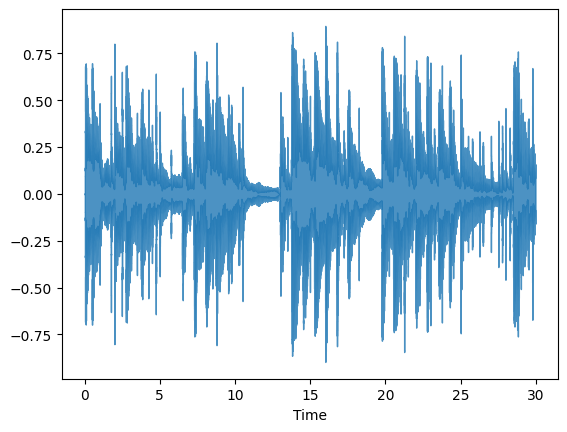

In [10]:
# Let's take an actual look at our song now
librosa.display.waveshow(song, sr = sr, alpha = 0.8);

This is more or less the standard way that a layperson would look at audio data. The issue here is that this more or less tells us that there's some sound at this time and that's nice but not very helpful to understand the song. Luckily, linear algebra's got our back and we can turn this data into something a bit more helpful to us. The standard process for visualizing audio data is called a Fourier Transform (more specifically a Fast Fourier Transform) and then computing a Mel Spectogram which essentially rescales our data to better represent how it is heard by human beings. The melspectogram, and the subsequent power to db transformation, will in effect take our raw audio data from the song and then aggregate across time and frequency. Frequency will be compressed into 128 "mel-bands" which are effectively frequency ranges that correspond to approximately equal amounts of perceived pitch differences. This is necessary because we perceive small shifts in lower-frequency sounds much better than be perceive them in higher-frequency sounds. For time, the transformation will then average the loudness (decibels as dB) across a small timespan. Combined, this allows each entry in the subsequent matrix to represent the loudness across a frequency range across a small span of time. 

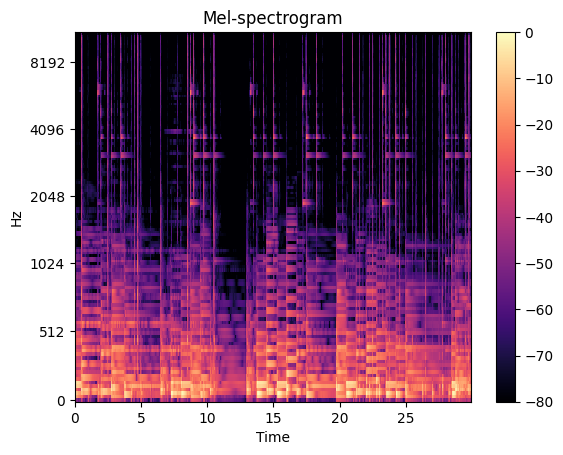

In [11]:
# Let's take a (better) look at our song

# Ref = np.max makes the plot easier to read compared to the default of 1
# the data we will feed into our model is referenced to 1 in the hope that values
# with negative and positives will give us a bit more separation and accuracy.
instr_mel = librosa.power_to_db(librosa.feature.melspectrogram(y = song, sr = sr), ref = np.max)

librosa.display.specshow(instr_mel, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title("Mel-spectrogram");

It's easiest to think of this plot as a heatmap where the brighter patches refer to louder sounds at that frequency at that time. There isn't too much we can say just from this graph however, since this graph is just one song with no real point of comparison. Let's compare to a song in a very different genre because that will give us some insight into how easy our model's job is going to be.

In [12]:
example_song = df[df['genre_top'] == 'Electronic'].sample(1) # choosing electronic for maximum visual difference
song, sr = librosa.load(get_path(example_song.index[0]))

# We can listen to it real quick as well
ipd.Audio(song, rate = sr)

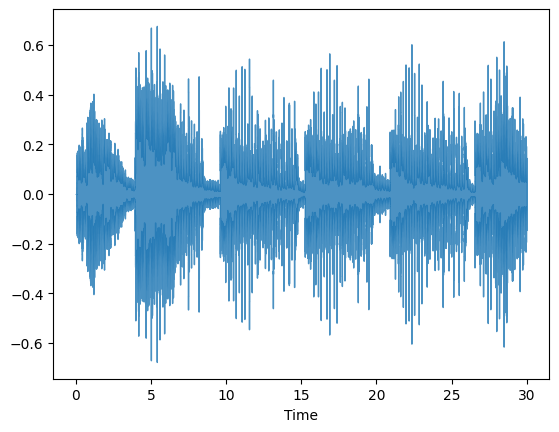

In [13]:
# Again, the waveplot doesn't say much but it is visually quite different
librosa.display.waveshow(song, sr = sr, alpha = 0.8); 

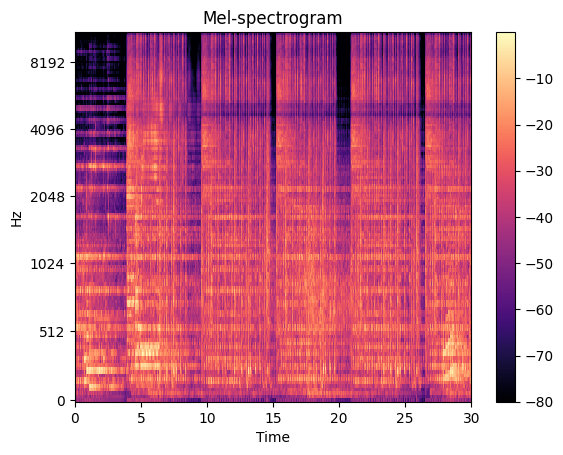

In [14]:
elec_mel = librosa.power_to_db(librosa.feature.melspectrogram(y = song, sr = sr), ref = np.max)

librosa.display.specshow(elec_mel, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title("Mel-spectrogram");

This is quite different so let's look at them side by side.

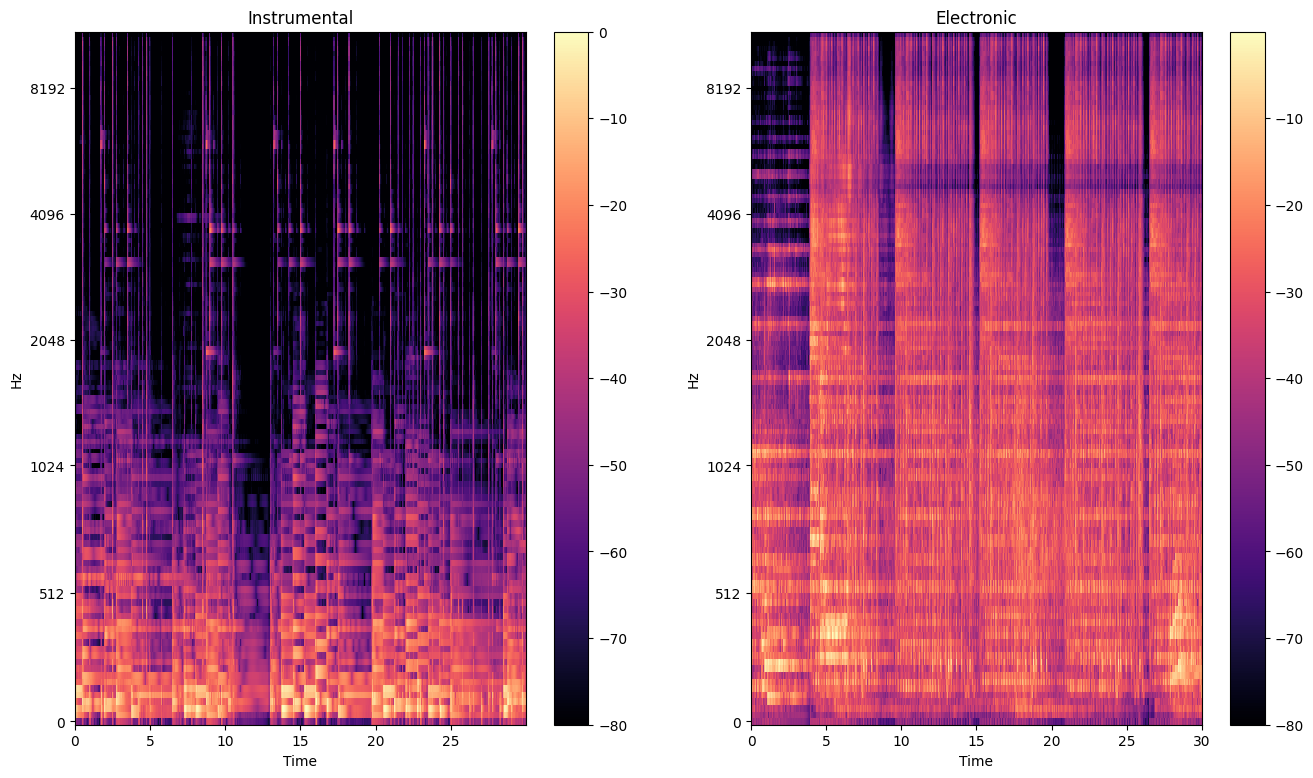

In [15]:
fig, ax = plt.subplots(ncols = 2, figsize = (16, 9))

inst_spec = librosa.display.specshow(instr_mel, x_axis='time', y_axis='mel', ax = ax[0])
plt.colorbar(inst_spec, ax = ax[0])
ax[0].set_title("Instrumental")

edm_spec = librosa.display.specshow(elec_mel, x_axis='time', y_axis='mel', ax = ax[1])
plt.colorbar(edm_spec, ax = ax[1])
ax[1].set_title('Electronic');

The waveplots from earlier did look a bit different but once we look at the frequencies directly we see that these songs look nothing alike which is quite interesting. The electronic song uses a much wider range of frequencies much more than the instrumental one which mostly stays in the bass to mid-bass ranges with some mid and high frequencies sporadically. By comparison, the electronic song is everywhere all at once all the time. Obviously, this is an extreme case but it is a good sign our model might have some real success.

This is about the extent of how we can explore our songs on an individual level using this data so let's instead consider some aggregate approaches.

In [16]:
# Gather unique genres
genres = df['genre_top'].unique()

# Initialize dictionary to store our mean-spectograms
genre_avg = dict()

for genre in genres:
    # Get indices of songs in genre
    subset_idx = df[df['genre_top'] == genre].index

    # Load in first song in genre
    song, sr = librosa.load(get_path(subset_idx[0]))
    # Calculate mel-spectogram
    mel = librosa.power_to_db(librosa.feature.melspectrogram(y = song, sr = sr), ref = np.max)[ : , :1291]
    
    # Keep count of how many songs 
    count = 1
    for idx in subset_idx[1:]:
        # Load in subsequent songs one by one
        song, sr = librosa.load(get_path(idx))
        # Add spectograms together
        mel += librosa.power_to_db(librosa.feature.melspectrogram(y = song, sr = sr), ref = np.max)[ : , :1291] 
        count += 1
    # Divide by count to get mean values
    genre_avg[genre] = mel/count

    # Delete data from memory to save RAM
    del song
    del sr
    del mel

    

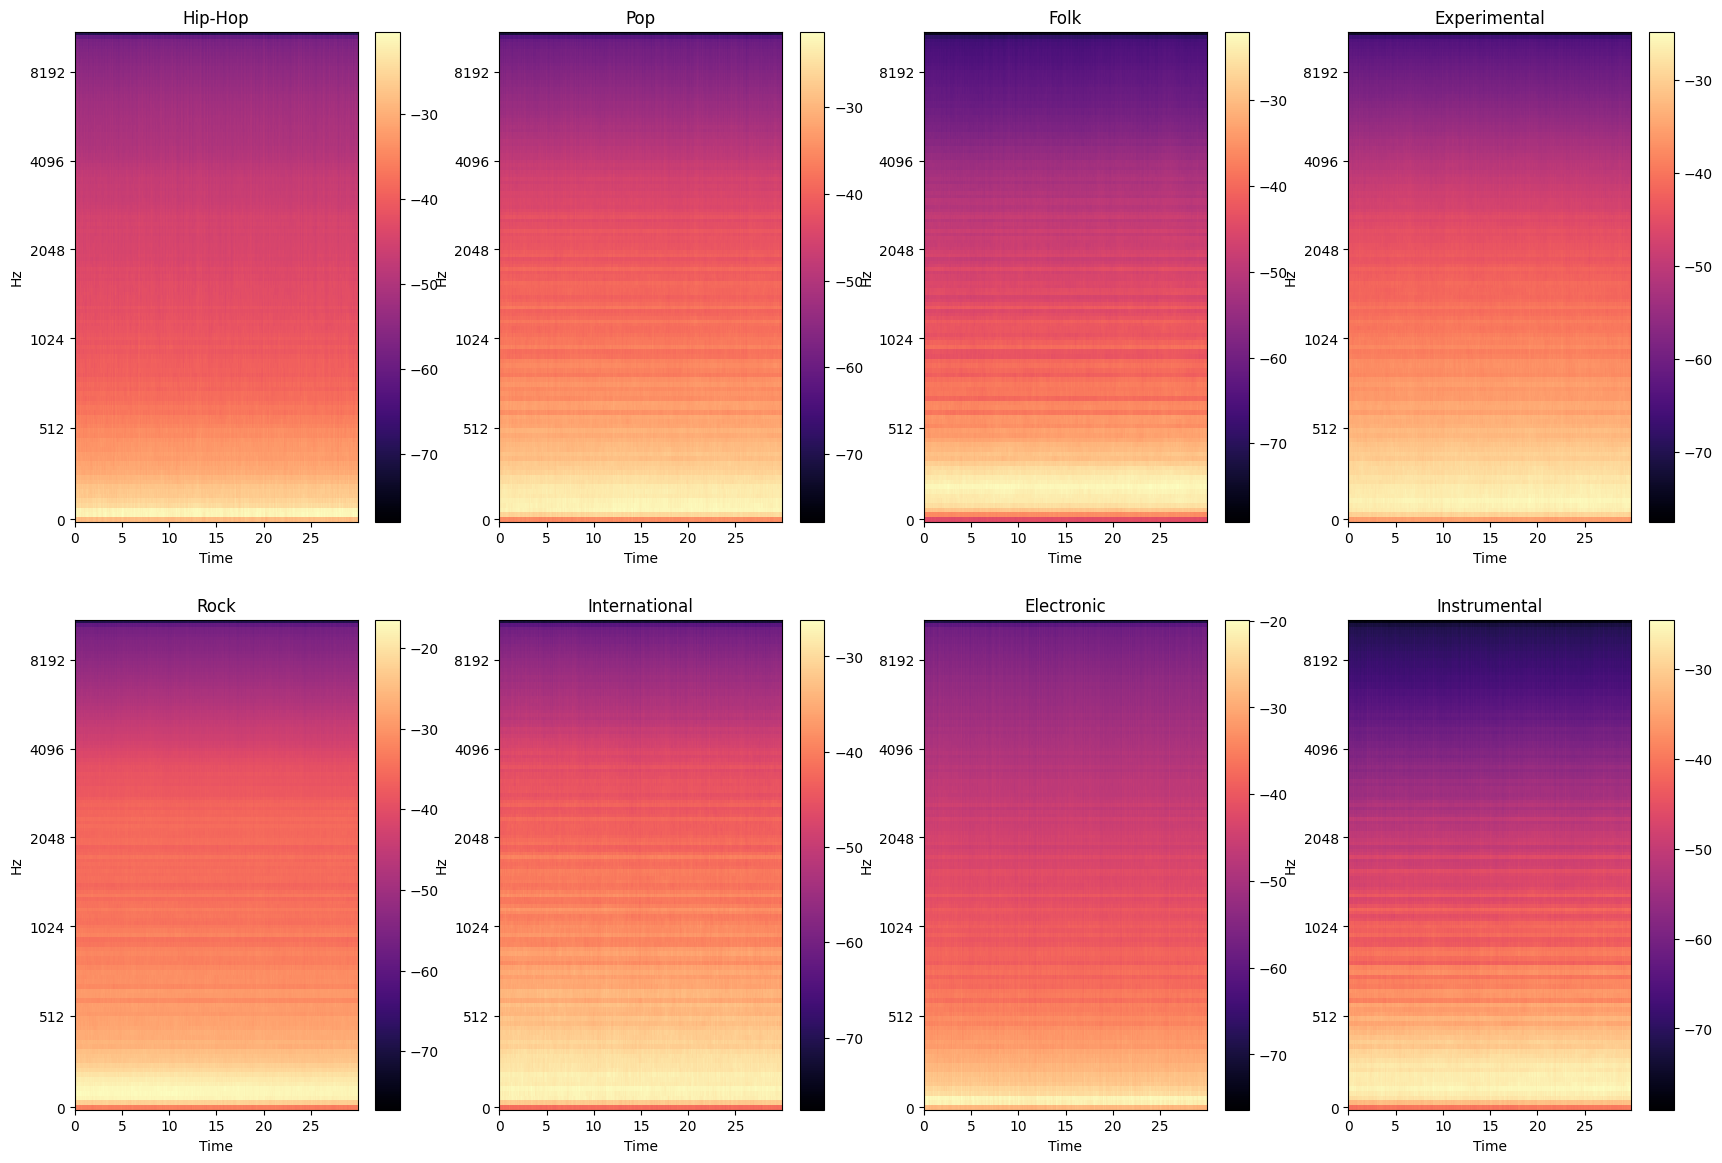

In [17]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (21, 14))

for key, axis in zip(genre_avg.keys(), ax.flatten()):
    plot = librosa.display.specshow(genre_avg[key], x_axis='time', y_axis='mel', ax = axis)
    plt.colorbar(plot, ax = axis)
    axis.set_title(key)

At first glance this is somewhere between mildly and incredibly troubling. By and large our plots look very similar but on closer glance there are some interesting differences. In particular the lowest frequencies (sub-bass) are much more present in the genres that use more synthetic tools in their music. For example, Instrumental has much less sub-bass than Electronic. Additionally, we see the more acoustic genres (Folk and Instrumental in particular) have much less prevalent higher frequencies which makes sense because its much harder to maintain those high frequency sounds using traditional methods whereas synthetic means can play whichever sounds they want. One thing to note is the scale for color is slightly different from genre to genre so in practice the differences are going to present a bit differently than they do here visually. 

An interesting thought is to look at the variances here, likely we won't be able to use this any insights here but let's take a moment solely to get a bit of a better understanding of the differences in our data.

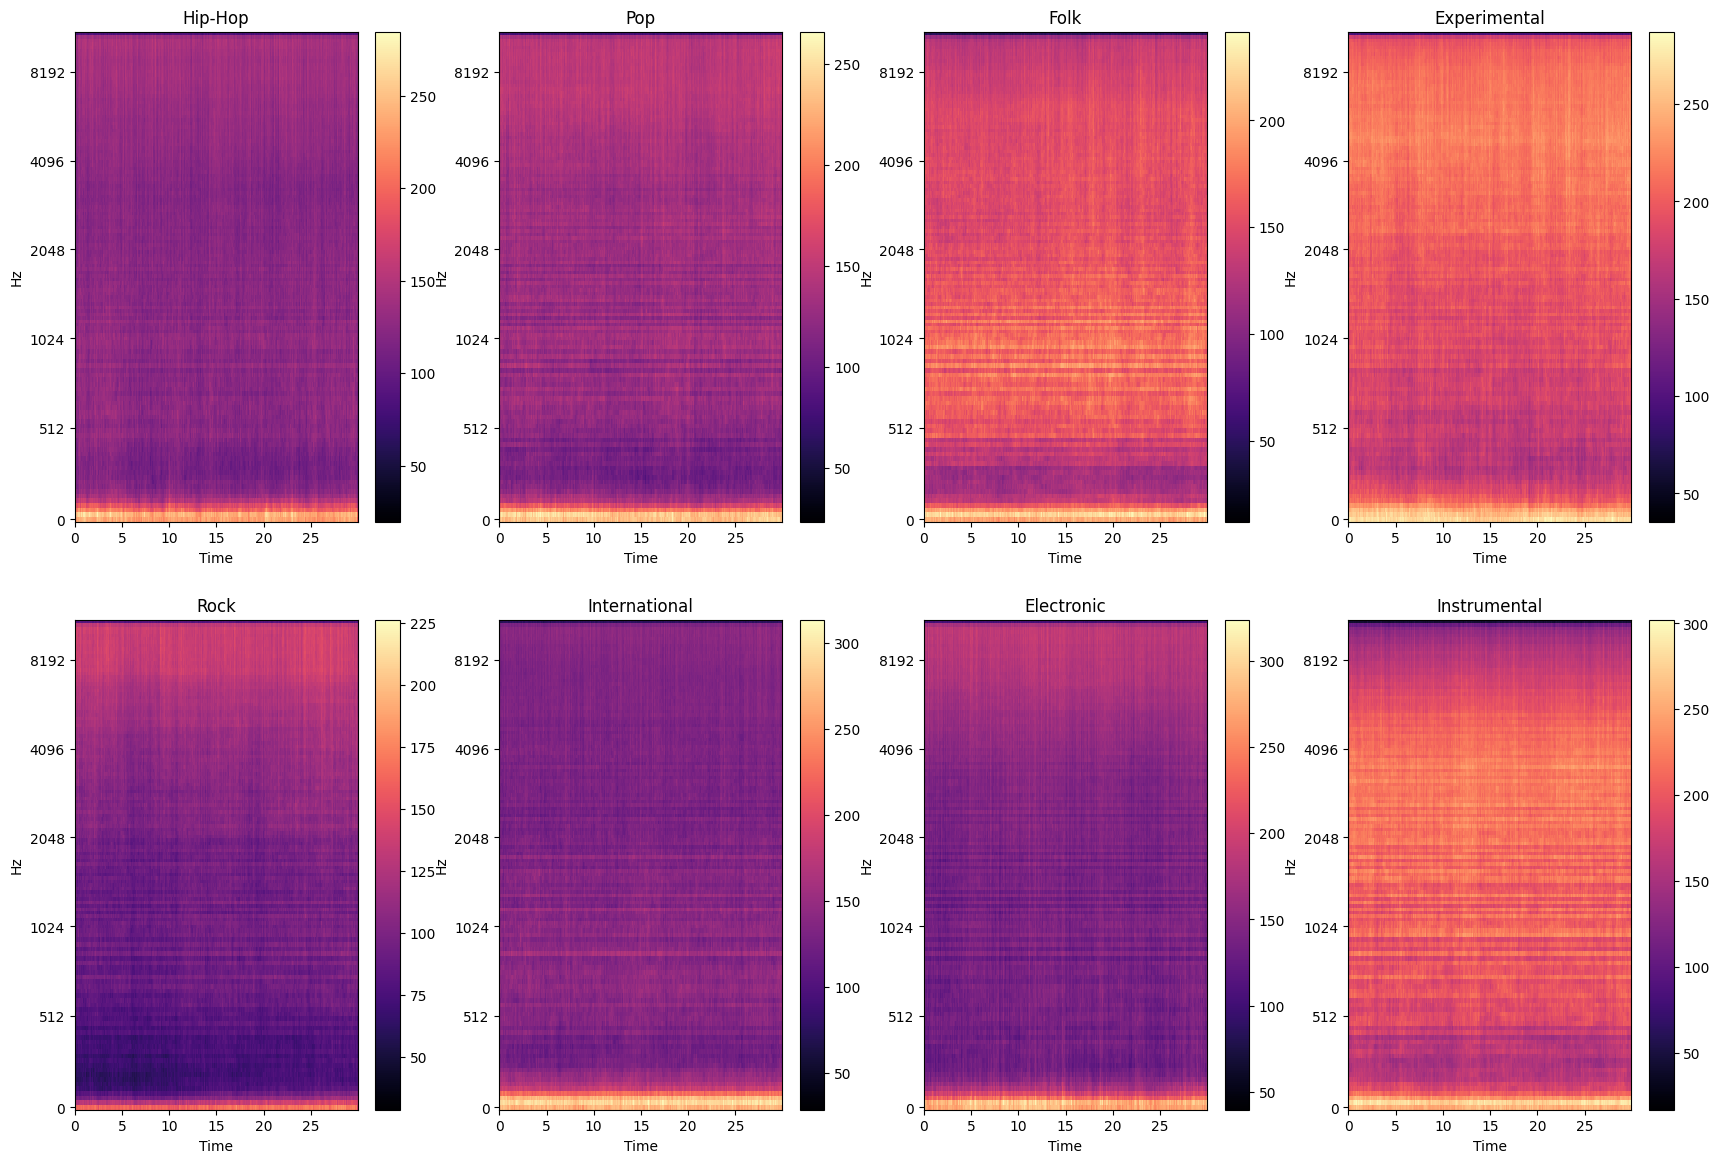

In [18]:
# Same process as before but calculating variance this time
genre_var = dict()

for genre in genres:
    subset_idx = df[df['genre_top'] == genre].index

    song, sr = librosa.load(get_path(subset_idx[0]))
    # Find squared error here instead of just the values
    mel = (librosa.power_to_db(librosa.feature.melspectrogram(y = song, sr = sr), ref = np.max)[ : , :1291] -  genre_avg[genre])**2
    
    count = 1
    for idx in subset_idx[1:]:
        song, sr = librosa.load(get_path(idx))

        mel += (librosa.power_to_db(librosa.feature.melspectrogram(y = song, sr = sr), ref = np.max)[ : , :1291] - genre_avg[genre])**2
        count += 1

    genre_var[genre] = mel/count

    del song
    del sr
    del mel


fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (21, 14))

for key, axis in zip(genre_var.keys(), ax.flatten()):
    plot = librosa.display.specshow(genre_var[key], x_axis='time', y_axis='mel', ax = axis)
    plt.colorbar(plot, ax = axis)
    axis.set_title(key)

This comparison is actually fascinating, we see a few different trends worth noting. First, Hip-Hop, Pop, International, and Electronic have near identical variance distributions at a glance. There's still some differences in there but the very high variance at low frequency combined with mostly even variance outside of that range is quite clear. On the other end, Folk, Experimental, and Instrumental have huge variance across the board with a slight reduction in the bass range. Again, these are interesting differences and help us understand the genres a bit better but its hard to say that these trends will help us with any classification down the line. 

There isn't _too_ much more EDA possible when working with songs at this level, that being said there is a somewhat interesting approach to consolidating songs we could use here. In the end, each song is being represented as a matrix and each matrix shares the same dimensions (in particular they share the same frequency bands) as each other matrix. Obviously, each band is meaningful and we want to include all of that info but the time domain is a bit more complicated. A song isn't defined by the noise at just a single moment, instead a song is defined across a sequential span in time. While the mel-spectrogram does condense time we still end up with quite a lot of time-segments per song as is. To reduce dimensions we're going to try a combination of two things. First, we'll aggregate our mel-bands across a span in time, by default we'll use 3 seconds or about a tenth of each song. With this, each song will be represented by 10 instances of 3 second intervals across our 128-band frequency range. Then, we can apply similar logic to above and aggregate. We'll calculate the mean values at each band along with the standard deviations at those bands. In doing so, we will transform our 128-band by 1291 time-segment song into 10 time-segments with 256 measures for that time-segment. The features will be the mean value at each band across that time segment along with the standard deviation for each band across that time segment (128 * 2 = 256). We will absolutely lose valuable information here, but our result will still have meaning and with these reduced dimensions we'll be able to apply Principle Component Analysis (PCA) in order to reduce our columns. In doing so, we'll be able to vastly reduce the computational expense of working with this data and hopefully still have a mostly valuable representation of the original song. To demonstrate that PCA on audio data works, let's try it quickly on a single song.

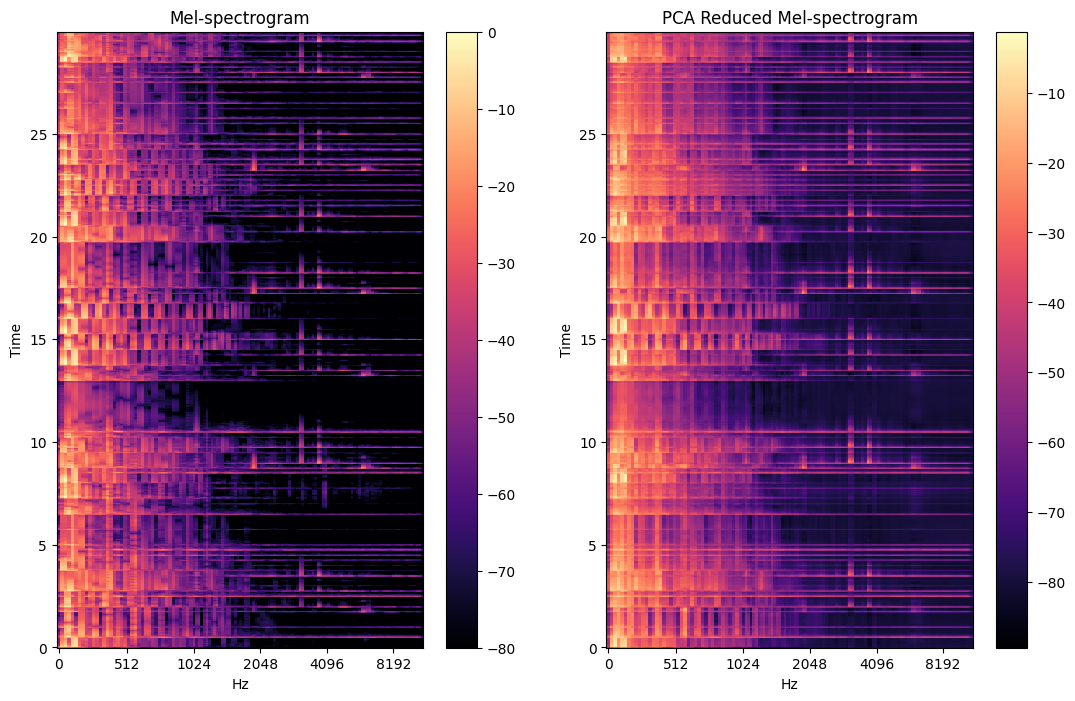

In [19]:
fig, ax = plt.subplots(ncols = 2, figsize = (13, 8))

scale = librosa.display.specshow(instr_mel.T, x_axis='mel', y_axis='time', ax = ax[0])
plt.colorbar(scale, ax = ax[0])
ax[0].set_title("Mel-spectrogram")

pca = PCA(0.85).fit(instr_mel.T) # Just using 85% as a default here

scale = librosa.display.specshow(pca.inverse_transform(pca.transform(instr_mel.T)), x_axis='mel', y_axis='time', ax = ax[1])
plt.colorbar(scale, ax = ax[1])
ax[1].set_title("PCA Reduced Mel-spectrogram");

We'll be using the transpose of the original matrix in order to preserve the time domain a bit more, the logic being we want the time-domain to retain its sequential nature and instead we want our PCA to combine the frequency bands to create our components. Hence, this plot is flipped from before. Generally, these look near identical, even just using a generic 85% variance cutoff for PCA. The largest difference is visually the darker patches in the original audio. Interestingly, if we look at the scale we see that the actual values are fairly close but the lower-bound on the PCA-reduced spectogram is a fair bit lower so it looks like there's a larger difference than there is in reality. All in all, we can feel okay with the assumption that PCA is applicable on audio-data when transformed into a spectogram.

 As a note, the process shown here is **not** the process described above or the final process for reducing dimensionality in our data. This is simply a convenient way to check that this process has some merit before we dive too deep. We will be losing more information when we aggregate across time and that will be a key difference between what we've just done with PCA and the end goal of this approach to reducing the size of this dataset. The actual process of decomposing our songs will be covered in a later modeling notebook, first we'll take a look at the more traditional CNN approach to classifying audio data.